In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [10]:
from helper import *
from copy import deepcopy
import pickle

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# MNIST Network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# MNIST Dataset (deterministic)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create datasets with fixed generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False, generator=g)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Example usage (deterministic training):
mnist_model = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.SGD(mnist_model.parameters(), lr=0.01)
mnist_losses, trained_mnist = train_model(mnist_model, mnist_train_loader, mnist_criterion, mnist_optimizer, num_epochs=5, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda


All seeds set to: 0
Model weights initialized with seed: 0
All seeds set to: 1
Model weights initialized with seed: 1
All seeds set to: 2
Model weights initialized with seed: 2
All seeds set to: 3
Model weights initialized with seed: 3
All seeds set to: 4
Model weights initialized with seed: 4


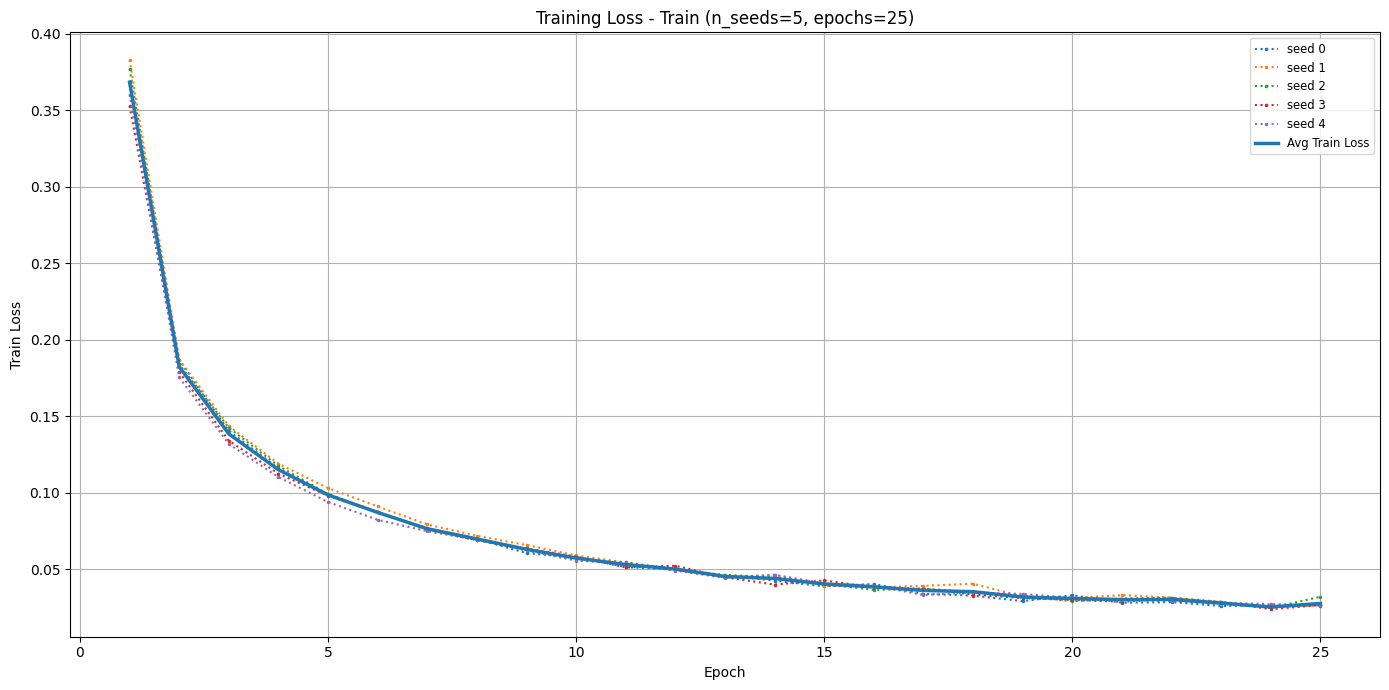

In [7]:
results_train = train_multiple_inits_and_plot(
    network_fn=lambda: MNISTNet(),
    train_loader=mnist_train_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer_fn=lambda m: optim.Adam(m.parameters(), lr=0.001),
    seeds=[0,1,2,3,4],
    num_epochs=25,                    # short for smoke test
    figsize=(14,7),
    plot_val=True,
    alpha=1
)

All seeds set to: 0
Model weights initialized with seed: 0
All seeds set to: 1
Model weights initialized with seed: 1
All seeds set to: 2
Model weights initialized with seed: 2
All seeds set to: 3
Model weights initialized with seed: 3
All seeds set to: 4
Model weights initialized with seed: 4


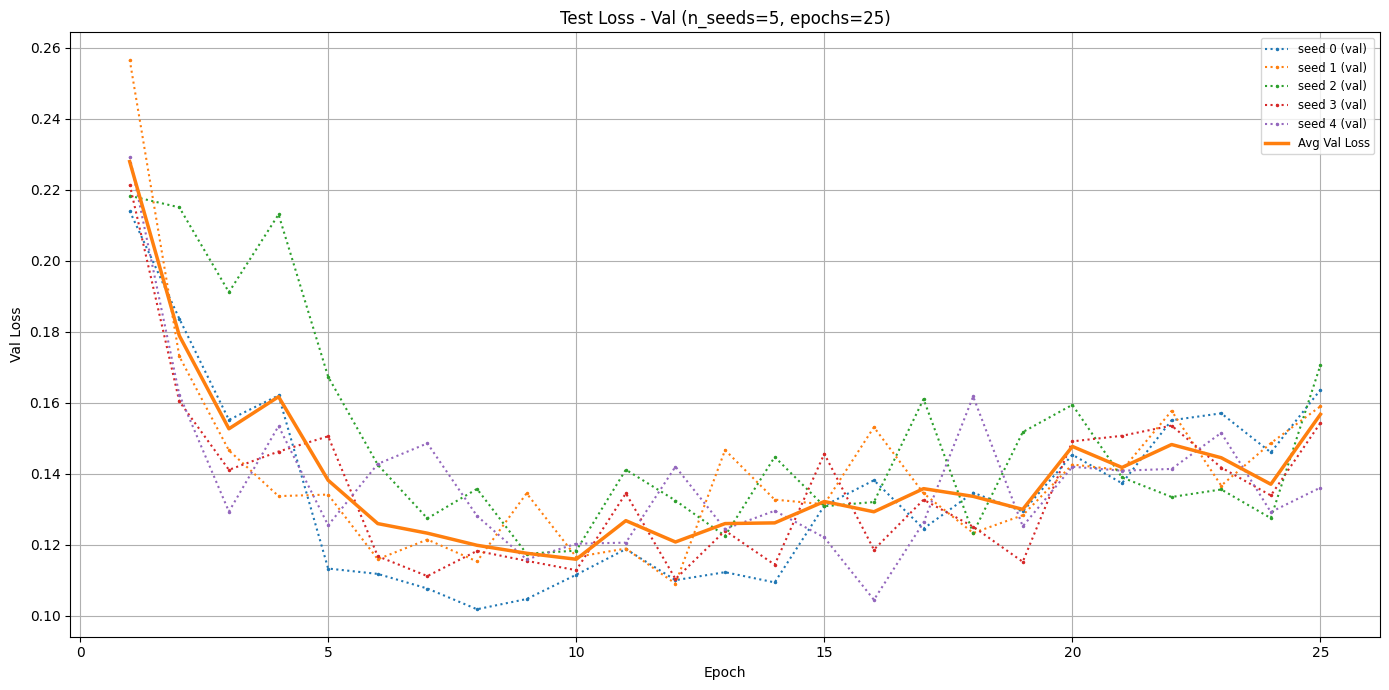

In [8]:
results_test = train_multiple_inits_and_plot(
    network_fn=lambda: MNISTNet(),
    train_loader=mnist_train_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer_fn=lambda m: optim.Adam(m.parameters(), lr=0.001),
    seeds=[0,1,2,3,4],
    num_epochs=25,
    figsize=(14,7),
    test_loader=mnist_test_loader,   # required for val runs
    plot_val=True,                  # allow val runs to be recorded/used
    loss_view="val",                # show only validation (test) loss
    alpha=1,
    title_prefix="Test Loss"
)

In [11]:
# Save knn_distances to a file
with open('losses/results_train.pkl', 'wb') as f:
    pickle.dump(results_train, f)  

# Save knn_distances to a file
with open('losses/results_test.pkl', 'wb') as f:
    pickle.dump(results_test, f)   